# Backtesting the "Cramer Effect"

**The cramer-effect/cramer-bounce**: After the show *Mad Money* the recommended stocks are bought by viewers almost immediately (afterhours trading) or on the next day at market open, increasing the price for a short period of time.

**Facts:**
- Mad money is from 6:00 PM to 7:00 PM ET
    - (This is 10:00 PM 11:00 PM UTC+0) 
- NYSE is open from 9:30 AM to 4:00 PM ET
    - (This is 1:30 PM to 8:00 PM UTC+0)

**Because of the above:**
- People buy the mentioned stocks
    - Next trading day at Open
    - After the show (7:00 PM ET)
        - As there is no (free) reliable afterhours market data, we will approximate the stock price as the price at 4:00 PM ET (NYSE Close)
- The increase is for a short period of time, but there are no exact figures, we can test on multiple hold horizons
    - Sell at next day Close
    - Sell after 1, 2, 3, ... days at Close

**Refs:**
- https://www.investopedia.com/terms/c/cramerbounce.asp
- https://www.kiplinger.com/article/investing/t031-c023-s001-the-cramer-effect.html
- https://www.davemanuel.com/investor-dictionary/cramer-effect/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from collections import Counter
from datetime import datetime, timedelta
from typing import List
import concurrent.futures

import numpy as np
import pandas as pd
import backtesting
from tqdm import tqdm
import yfinance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import mad_money_backtesting as mmb

Loading BokehJS ...

# Constants

In [4]:
# This is the date which we will use as the first day for backtesting
BACKTEST_FROM = "2020-01-01"

# You should only lower this, as this is the max value on Cramers page.
# Lower when you want to buy cheaper stocks
CASH_PER_STOCK = 1000

# Commission payed when you open a position (defined in %) - Increase it a little
# so you count with the slippage as well
COMMISSION_RATE = 0.02

# This is the strategy which you will use for the backtesting
BACKTESTING_STRATEGY = mmb.BuyAndHold
# Some strategies may require extra parameters, you can define them here (e.g. BuyAndHold needs sell_horizon)
# STRATEGY_EXTRA_PARAMS = {}
STRATEGY_EXTRA_PARAMS = {"sell_horizon": 10000}

In [5]:
# The number of business days where we have some values about the market
NB_BUSINESS_DAYS = len(pd.bdate_range(BACKTEST_FROM, datetime.now()))
print(f"Number of business days needed to fully test the stocks: {NB_BUSINESS_DAYS}")

Number of business days needed to fully test the stocks: 373


# Read the csv

In [6]:
df = pd.read_csv("mad_money_recommendations.csv", parse_dates=["date"])

In [7]:
df.head()

,name,month_and_day,segment,call,current_price,date,symbol
0,AGNC Investment (AGNC),01/03,L,negative,17.73,2020-01-03,AGNC
1,Advanced Micro Devices (AMD),01/03,D,buy,48.60,2020-01-03,AMD
2,Alibaba (BABA),01/03,L,buy,217.00,2020-01-03,BABA
3,American Express (AXP),01/03,D,buy,124.60,2020-01-03,AXP
4,Apple (AAPL),01/03,D,buy,297.43,2020-01-03,AAPL


# Filter the data

## Call type filter

We only care about the "buy" mentions, but this can be extended to the "positive" mentions as well

In [8]:
df = df[df["call"] == "buy"]

# Backtest all mentioned stocks

## Filter based on the date

In [9]:
if BACKTEST_FROM is None:
    BACKTEST_FROM = df["date"].values[0]

In [10]:
df = df[df["date"] >= BACKTEST_FROM]

In [11]:
print(f"Backtesting starts from {df.date.values[0]} and lasts until {df.date.values[-1]}")

Backtesting starts from 2020-01-03T00:00:00.000000000 and lasts until 2021-05-27T00:00:00.000000000


## Define backtesting for a single stock

With the `backtesting.py` framework every single stock is backtested separately. For each stock we have `X` money which we are willing to spend (e.g. $5k), this is defined at the start of the notebook.

On the buy dates (which are calulated in the backtesting class) we go all-in with the money which we have (which is left) for the stock, and every sell date, we sell every long position.

*(There is a possiblinily to define stop-loss and take-profit, but as defualt these are not used.)*

Yes, this differs from a real-life scenario, I collected the major differences in the `README.md`

In [12]:
def backtest_single_stock(strategy_class, symbol, mad_money_df, cash, commission,
                          stop_loss_perc=None, take_profit_perc=None):
    # Get the dates when the Stock was recommended
    recommendation_dates = mad_money_df[mad_money_df["symbol"] == symbol]["date"]
    recommendation_dates = [mmb.pd_date_to_datetime(x) for x in recommendation_dates]
    
    # Download the stock data - with pre and post data
    stock_df = yfinance.Ticker(symbol).history(period=f"{NB_BUSINESS_DAYS}d", interval="1h", prepost=False)
    if len(stock_df) < 1:
        raise ValueError(f"There is not data in the dataframe for: {symbol}")
    stock_df["Date"] = stock_df.index
    stock_df.dropna(inplace=True)
    
    # Run the backtesting with our strategy
    bt = backtesting.Backtest(stock_df, strategy_class, cash=cash, commission=commission, trade_on_close=True)
    results = bt.run(recommendation_dates=recommendation_dates,
                     stop_loss_perc=stop_loss_perc,
                     take_profit_perc=take_profit_perc,
                     **STRATEGY_EXTRA_PARAMS)
    
    return bt, results

## Run backtests

(For each stock the backtesting will run in parallel speeding up the process)

In [13]:
stocks_to_backtest = df["symbol"].unique()
pbar = tqdm(total=len(stocks_to_backtest), desc="Backtesting...")

bt_results = {}
symbols_not_used_at_the_end = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {}
    
    for symbol in stocks_to_backtest:
        f = executor.submit(backtest_single_stock,
                            strategy_class=BACKTESTING_STRATEGY,
                            symbol=symbol,
                            mad_money_df=df,
                            cash=CASH_PER_STOCK,
                            commission=COMMISSION_RATE)
        futures[f] = symbol
        
    for f in concurrent.futures.as_completed(futures):
        symbol = futures[f]
        
        try:
            bt_obj, bt_result = f.result()
            bt_results[symbol] = {"obj":bt_obj, "result":bt_result}
        except Exception as e:
            print(f"There was a problem with {symbol} - {e}")
            # print(traceback.print_exc())
            symbols_not_used_at_the_end.append(symbol)
            
        pbar.update(1)
            
pbar.close()

Backtesting...:   3%|▎         | 22/736 [00:05<02:57,  4.02it/s]

- AAXN: No data found, symbol may be delisted
There was a problem with AAXN - There is not data in the dataframe for: AAXN


Backtesting...:   8%|▊         | 60/736 [00:12<02:22,  4.75it/s]

- PE: No data found, symbol may be delisted
There was a problem with PE - There is not data in the dataframe for: PE


Backtesting...:  10%|▉         | 71/736 [00:14<02:21,  4.69it/s]

- BRK.B: No data found, symbol may be delisted
There was a problem with BRK.B - There is not data in the dataframe for: BRK.B


Backtesting...:  11%|█▏        | 83/736 [00:16<02:56,  3.69it/s]

- UTX: No data found, symbol may be delisted
There was a problem with UTX - There is not data in the dataframe for: UTX


Backtesting...:  21%|██▏       | 157/736 [00:29<01:37,  5.92it/s]

- AGN: No data found, symbol may be delisted
There was a problem with AGN - There is not data in the dataframe for: AGN


Backtesting...:  23%|██▎       | 166/736 [00:31<01:53,  5.03it/s]

- RTN: No data found, symbol may be delisted
There was a problem with RTN - There is not data in the dataframe for: RTN


Backtesting...:  26%|██▌       | 189/736 [00:35<01:24,  6.51it/s]

- SNE: No data found, symbol may be delisted
There was a problem with SNE - There is not data in the dataframe for: SNE


Backtesting...:  31%|███       | 225/736 [00:42<01:56,  4.38it/s]

- LVGO: No data found, symbol may be delisted
There was a problem with LVGO - There is not data in the dataframe for: LVGO


Backtesting...:  32%|███▏      | 235/736 [00:43<01:48,  4.61it/s]

- AIMT: No data found, symbol may be delisted
There was a problem with AIMT - There is not data in the dataframe for: AIMT


Backtesting...:  34%|███▍      | 249/736 [00:45<01:18,  6.19it/s]

- SQ : No data found, symbol may be delisted
There was a problem with SQ  - There is not data in the dataframe for: SQ 


Backtesting...:  44%|████▍     | 327/736 [01:00<01:08,  5.99it/s]

- HMSY: No data found, symbol may be delisted
There was a problem with HMSY - There is not data in the dataframe for: HMSY


Backtesting...:  60%|██████    | 445/736 [01:22<00:43,  6.75it/s]

- CCH: No data found, symbol may be delisted
There was a problem with CCH - There is not data in the dataframe for: CCH


Backtesting...:  61%|██████    | 448/736 [01:22<00:37,  7.71it/s]

- RST: No data found, symbol may be delisted
There was a problem with RST - There is not data in the dataframe for: RST


Backtesting...:  62%|██████▏   | 459/736 [01:24<00:45,  6.15it/s]

- SERV: No data found, symbol may be delisted
There was a problem with SERV - There is not data in the dataframe for: SERV


Backtesting...:  66%|██████▌   | 484/736 [01:28<00:43,  5.76it/s]

- MU : No data found, symbol may be delisted
There was a problem with MU  - There is not data in the dataframe for: MU 


Backtesting...:  66%|██████▌   | 486/736 [01:28<00:37,  6.68it/s]

- MOG.A: No data found, symbol may be delisted
There was a problem with MOG.A - There is not data in the dataframe for: MOG.A


Backtesting...:  70%|███████   | 516/736 [01:33<00:39,  5.56it/s]

- SEAH.U: No data found, symbol may be delisted
There was a problem with SEAH.U - There is not data in the dataframe for: SEAH.U


Backtesting...:  79%|███████▉  | 581/736 [01:43<00:23,  6.49it/s]

- PIC: No data found, symbol may be delisted
There was a problem with PIC - There is not data in the dataframe for: PIC


Backtesting...:  81%|████████  | 597/736 [01:45<00:16,  8.48it/s]

- NK: No data found, symbol may be delisted
There was a problem with NK - There is not data in the dataframe for: NK


Backtesting...:  82%|████████▏ | 601/736 [01:46<00:21,  6.23it/s]

- FCAU: No data found, symbol may be delisted
There was a problem with FCAU - There is not data in the dataframe for: FCAU


Backtesting...:  83%|████████▎ | 610/736 [01:47<00:19,  6.60it/s]

- CIIC: No data found, symbol may be delisted
There was a problem with CIIC - There is not data in the dataframe for: CIIC


Backtesting...:  83%|████████▎ | 614/736 [01:48<00:16,  7.30it/s]

- BFT: No data found, symbol may be delisted
There was a problem with BFT - There is not data in the dataframe for: BFT


Backtesting...:  84%|████████▍ | 620/736 [01:49<00:16,  6.87it/s]

- SBE: No data found, symbol may be delisted
There was a problem with SBE - There is not data in the dataframe for: SBE


Backtesting...: 100%|██████████| 736/736 [02:06<00:00,  5.82it/s]


In [14]:
print(f"These symbols were not backtested, but Cramer mentioned them: {symbols_not_used_at_the_end}")

These symbols were not backtested, but Cramer mentioned them: ['AAXN', 'PE', 'BRK.B', 'UTX', 'AGN', 'RTN', 'SNE', 'LVGO', 'AIMT', 'SQ ', 'HMSY', 'CCH', 'RST', 'SERV', 'MU ', 'MOG.A', 'SEAH.U', 'PIC', 'NK', 'FCAU', 'CIIC', 'BFT', 'SBE']


# Results

In [15]:
results_df = mmb.summarize_backtesting_results(results=[x["result"] for x in bt_results.values()],
                                               symbols=list(bt_results.keys()),
                                               include_parameters=False,
                                               sort_by="Return [%]")

In [16]:
returns_perc = results_df["Return [%]"].values

## Mean and Median returns

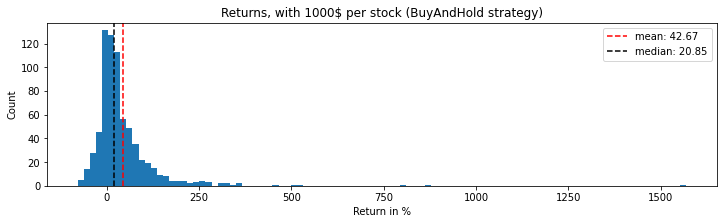

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.hist(returns_perc, bins=100)
ax.set_title(f"Returns, with {CASH_PER_STOCK}$ per stock ({BACKTESTING_STRATEGY.__name__} strategy)")
ax.set_ylabel("Count")
ax.set_xlabel("Return in %")
ax.axvline(returns_perc.mean(), color="red", linestyle="--", label=f"mean: {returns_perc.mean():.2f}")
ax.axvline(np.median(returns_perc), color="black", linestyle="--", label=f"median: {np.median(returns_perc):.2f}")
ax.legend();

## Returns by profit or loss

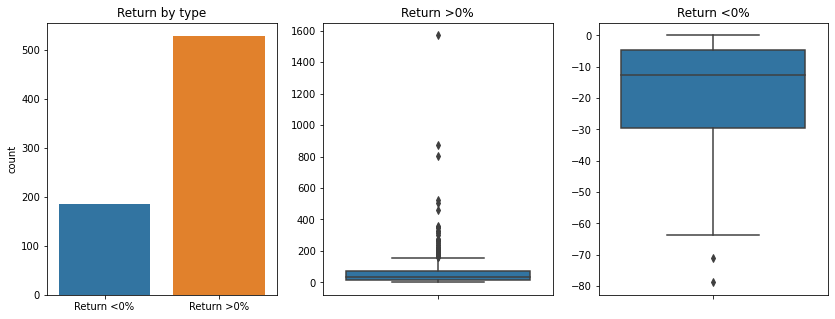

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 5))

return_types = np.where(returns_perc > 0, 1, 0)
return_type_labels = ["Return <0%", "Return >0%"]
pos_return_mask = return_types == 1

sns.countplot(return_types, ax=ax0)
ax0.set_title("Return by type")
ax0.set_xticklabels(return_type_labels)

sns.boxplot(y=returns_perc[pos_return_mask], ax=ax1)
ax1.set_title(return_type_labels[1])

sns.boxplot(y=returns_perc[~pos_return_mask], ax=ax2)
ax2.set_title(return_type_labels[0]);

## Complete stock list

Usually this is a longer list (~600 rows), which does not really fits in the notebook, so we will create a separate HTML file to store the values

In [19]:
list_html_file_name = "complete_backtest_list.html"

with open(list_html_file_name, "w") as f:
    df_html = results_df.style.background_gradient(cmap="magma_r").render()
    df_html = mmb.paginated_html_table(df_html)
    f.write(df_html)

In [20]:
# from IPython.display import HTML, display
# display(HTML(filename=list_html_file_name))

## Individual stock backtesting inspection

If you would like to inspect the backtesting plot of any individual stock, just uncomment the following cells/lines

In [21]:
symbol_to_inspect = "TSLA"
df[df["symbol"] == symbol_to_inspect]

,name,month_and_day,segment,call,current_price,date,symbol
57,Tesla (TSLA),01/06,L,buy,451.54,2020-01-06,TSLA
69,Tesla (TSLA),01/07,F,buy,469.06,2020-01-07,TSLA
91,Tesla (TSLA),01/08,D,buy,492.14,2020-01-08,TSLA
139,Tesla (TSLA),01/13,D,buy,524.86,2020-01-13,TSLA
218,Tesla (TSLA),01/22,F,buy,569.56,2020-01-22,TSLA
...,...,...,...,...,...,...,...
4862,Tesla (TSLA),04/23,D,buy,729.40,2021-04-23,TSLA
4943,Tesla (TSLA),04/29,L,buy,677.00,2021-04-29,TSLA
5106,Tesla (TSLA),05/10,D,buy,629.04,2021-05-10,TSLA
5121,Tesla (TSLA),05/11,D,buy,617.20,2021-05-11,TSLA


In [25]:
bt_results[symbol_to_inspect]["obj"].plot(superimpose=False)

# Manually collected stats

In [23]:
(~(return_types == 1)).sum(), (return_types == 1).sum(), returns_perc.mean(), np.median(returns_perc)

(185, 528, 42.67458882068666, 20.850483856201162)

- Buy and hold:
    - Data range: 2020-01-01 --> 2021-06-04
    - Recommendation range: Starts at 2020-01-03T00:00:00.000000000 and lasts until 2021-05-27T00:00:00.000000000
    - until now (~373 days): 186, 529, 42.68632506772485, 20.644652080535888
    - 1 day: 543, 170, -4.854356827159822, -3.011536590576179
    - 2 days: 523, 190, -4.388444272957948, -3.371403350830087
    - 5 days: 481, 232, -3.039593245566169, -2.724342590332083
    - 10 days: 455, 258, -3.0977166393622713, -3.42915859985352
    - 30 days: 385, 328, 1.848991565331101, -1.9344852294921906
    - 60 days: 348, 365, 9.750032702013764, 0.6996536254882585
    - 90 days: 329, 383, 12.109622220755437, 2.705466440200803
    - 120 days: 295, 418, 17.63430132436048, 5.150333183288581
    - 240 days: 227, 486, 31.576162330847115, 12.196797821044925
    - 365 days: 215, 498, 38.80414885588127, 18.16746044921874
    - Buy at first mention and hold: 185, 528, 42.67458882068666, 20.850483856201162